### Kontury

Z reguły w końcowym etapie analizy obrazu chcemy informację rastrową (piksele) przekształcić do postaci "logicznej", na przykład listy obiektów opisanych prostokątami otaczającymi (_bounding box_).
OpenCV oferuje funkcję [`findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0), która z jednokanałowego obrazu binarnego ekstrahuje _kontury_ - krzywe łączące punkty na krawędziach obszarów o tej samej wartości.
Przeanalizujmy jej działanie na przykładzie poniższego obrazu ([źródło](https://commons.wikimedia.org/wiki/Category:Snooker?uselang=pl#/media/File:Atlantis_billiard_club_-_near_Be'sat_sq_-_Nishapur_18.JPG)).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

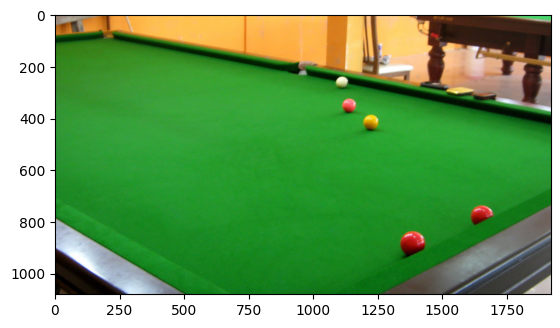

In [3]:
src = cv2.imread('snooker.jpg')
plt.imshow(src[..., ::-1]); # ::-1  --  konwersja "w locie" do RGB

Zaczniemy oczywiście od dokonania prostej binaryzacji.
Dla uproszczenia przykładu, skupimy się na wykryciu kolorowych bil na zielonym tle.

Pro-tip: filtrowanie po podstawowych kolorach (RGBY) jest bardzo łatwe w przestrzeni CIELAB.

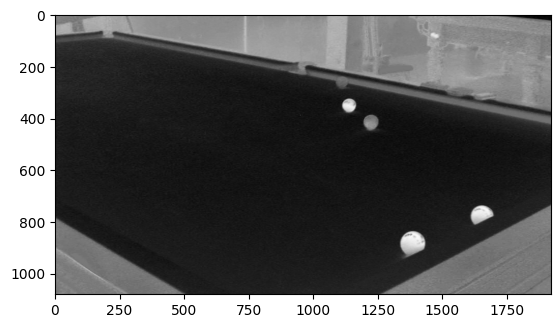

In [4]:
gray = cv2.cvtColor(src, cv2.COLOR_BGR2LAB)[..., 1] # kanał 'a' w przestrzeni CIELAB
plt.imshow(gray, cmap='gray');

Po prostym progowaniu uzyskamy:

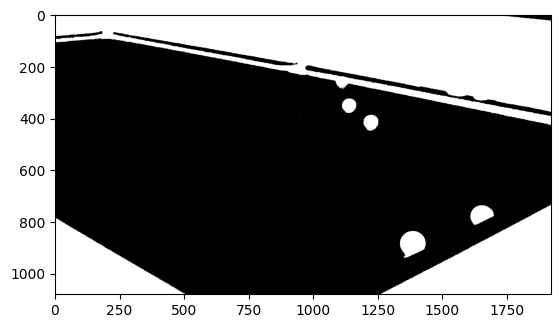

In [5]:
_, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
plt.imshow(binary, cmap='gray');

In [6]:
binary.dtype, binary.max()

(dtype('uint8'), 255)

Po upewnieniu się, że obraz jest odpowiedniego typu, przechodzimy do wykrycia konturów. Zwróć uwagę na argumenty funkcji:
* `image`: obraz źródłowy
* `mode`: tryb ekstrakcji konturów ([`cv::RetrievalModes`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71))
* `method`: metoda aproksymacji konturów ([`cv2.ContourApproximationModes`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga4303f45752694956374734a03c54d5ff))

W naszym prostym przypadku wystarczy ekstrakcja konturów zewnętrznych (`cv2.RETR_EXTERNAL`) i podstawowy algorytm upraszczania `cv2.CHAIN_APPROX_SIMPLE`.

In [7]:
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Funkcja zwraca dwa obiekty: `contours` to lista zawierająca poszczególne kontury; `hierarchy` pozwala odtworzyć relacje między konturami (jeśli np. któryś kontur otacza inny).
Z reguły najistotniejsze są same kontury, dlatego to nim przyjrzymy się bliżej.

In [8]:
print(len(contours), type(contours[0]))

16 <class 'numpy.ndarray'>


In [9]:
print(contours[3].shape, contours[4].shape)

(138, 1, 2) (456, 1, 2)


In [9]:
contours[3].dtype

dtype('int32')

Zwróć uwagę na niecodzienny kształt tablic tworzących poszczególne kontury: ich wymiar to zawsze (N,1,2), gdzie N jest liczbą punktów, a w trzecim wymiarze znajdują się koordynaty X i Y punktów wchodzących w skład konturu.

---
Kontury możemy narysować za pomocą funkcji [`cv2.drawContours`](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc) - do doczytania.

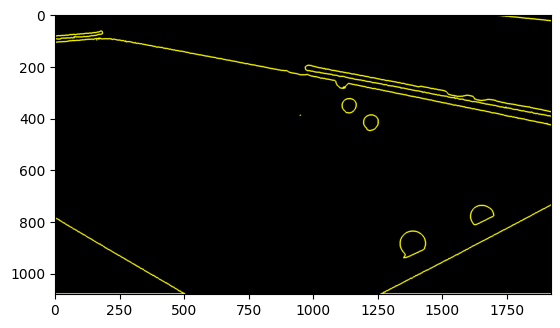

In [10]:
display = np.zeros_like(src)
cv2.drawContours(display, contours, -1, (255, 255, 0), 3)
plt.imshow(display);

---
Przeszliśmy w ten sposób z reprezentacji rastrowej do wektorowej.
Możemy ją teraz na różne sposoby wykorzystać, na przykład analizując geometrię konturów...

In [11]:
correct = [c for c in contours if c.shape[0] > 3] # odsiewamy artefakty detekcji

In [12]:
balls = [c for c in correct if cv2.contourArea(c) < 10000] # odsiewamy kontury po polu powierzchni

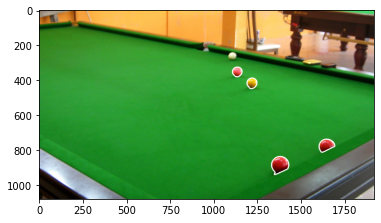

In [13]:
display = src.copy()
cv2.drawContours(display, list(balls), -1, (255, 255, 255), 5)
plt.imshow(display[..., ::-1]);

...albo uzyskując rejon zainteresowania (_RoI_) w okolicy interesującego obiektu.

In [14]:
x, y, w, h = cv2.boundingRect(balls[2])

In [15]:
x, y, w, h

(1192, 388, 57, 62)

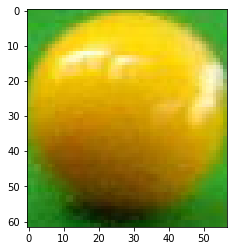

In [16]:
roi = src[y:y+h, x:x+w, :]
plt.imshow(roi[..., ::-1]);